In [ ]:
import numpy as np
import math
import time
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(7)
random.seed(7)

In [ ]:
train_data = torchvision.datasets.EMNIST(root='./EMNST',split='bymerge', train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.EMNIST(root='./EMNST',split='bymerge', train=False, transform=transforms.ToTensor())

Extracting ./EMNST/EMNIST/raw/emnist.zip to ./EMNST/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [ ]:
len(train_data),len(test_data)

(697932, 116323)

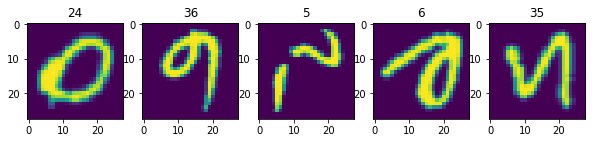

In [ ]:
plt.figure(figsize=(10,5))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_data[i][0].squeeze())
  plt.title(train_data[i][1])
plt.show()

In [ ]:
train_loader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=False)

In [ ]:
len(train_loader),len(test_loader)

(10906, 1818)

In [ ]:
class DenseUnit(nn.Module):
    def __init__(self, in_planes ,growth_rate, dropRate=0.0):
        super(DenseUnit,self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels= in_planes, out_channels= growth_rate*4, kernel_size=1, stride=1,padding=0,bias=False)
        self.bn2 = nn.BatchNorm2d(growth_rate*4)
        self.conv2 = nn.Conv2d(in_channels= growth_rate*4,out_channels= growth_rate, kernel_size=3, stride=1,padding=1,bias=False)
        self.dropout = dropRate

    def forward(self, x):
        h = self.bn1(x)
        h = self.relu(h)
        h = self.conv1(h)
        if self.dropout>0:
          h = F.dropout(h, p=self.dropout)
        h = self.conv2(self.relu(self.bn2(h)))
        if self.dropout>0:
          h = F.dropout(h, p=self.dropout)
        return torch.cat([x,h],dim=1)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(in_planes, growth_rate, nb_layers, dropRate)

    def _make_layer(self, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
          in_ch = in_planes + growth_rate * i
          layers.append(DenseUnit(in_ch, growth_rate,dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

In [ ]:
class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels= in_planes,out_channels= out_planes, kernel_size=1, stride=1,padding=0,bias=False)
        self.pool = nn.AvgPool2d(kernel_size= 2,stride=2)
        self.dropout = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.dropout>0.0:
          out=F.dropout(out,p=self.dropout)
        return self.pool(out)

In [ ]:
class Densenet(nn.Module):
  def __init__(self, growth_rate=32, depth, num_classes, reduction=0.5, dropRate=0.0):
    super(Densenet,self).__init__()
    in_planes = 2 * growth_rate
    n=(depth-4)/3
    n=n/2
    n=int(n)

    self.conv1 = nn.Conv2d(1,in_planes, kernel_size= 3, padding=1)
    self.dl1 = DenseBlock(n,in_planes,growth_rate)
    in_planes = int(in_planes+n*growth_rate)
    self.tr1 = TransitionBlock(in_planes,int(math.floor(in_planes*reduction)),dropRate)
    in_planes = int(math.floor(in_planes*reduction))

    self.dl2 = DenseBlock(n,in_planes,growth_rate,dropRate)
    in_planes = int(in_planes+n*growth_rate)
    self.tr2 = TransitionBlock(in_planes,int(math.floor(in_planes*reduction)),dropRate)
    in_planes=int(math.floor(in_planes*reduction))

    self.dl3=DenseBlock(n,in_planes,growth_rate,dropRate)
    in_planes = int(in_planes+n*growth_rate)

    self.bn=nn.BatchNorm2d(in_planes)
    self.relu=nn.ReLU()
    self.fc=nn.Linear(in_planes,num_classes)

  def forward(self,x):
    x=self.conv1(x)
    x=self.dl1(x)
    x=self.tr1(x)
    x=self.dl2(x)
    x=self.tr2(x)
    x=self.dl3(x)

    x=self.relu(self.bn(x))
    x= F.avg_pool2d(x, kernel_size=7)

    x=x.reshape(x.size(0),-1)
    x=self.fc(x)

    return x

In [ ]:
lr=0.001
epochs=4

In [ ]:
torch.manual_seed(17404574258890175341)
torch.cuda.manual_seed_all(1852927266102222)
model_Dense=Densenet(depth=28, num_classes=47).to(device)
criterion=nn.CrossEntropyLoss()
optm=optim.Adam(model_Dense.parameters(),lr=lr)
decay_epoch=[500000,600000]
step_lr_scheduler=torch.optim.lr_scheduler.MultiStepLR(optm,milestones=decay_epoch,gamma=0.7)

In [ ]:
# Training
running_losses=[]
start=time.time()
for epoch in range(epochs):
    model_Dense.train()
    running_loss=0
    for i,(images,labels) in enumerate(train_loader):
        images=images.to(device)
        labels=labels.to(device)
        optm.zero_grad()
        outputs=model_Dense(images)

        loss=criterion(outputs,labels)
        loss.backward()
        optm.step()
        step_lr_scheduler.step()

        running_loss+=loss.item()

        if (i%2000==1999):
            print("Epoch [{}/{}] , Step [{}/{}], Loss {:.4f}".format(epoch+1,epochs,i+1,len(train_loader),running_loss/2000))
            running_losses.append(running_loss/2000)
            running_loss=0
            if (epoch==3 and i==7999):
              break

end=time.time()
print("Take time : %.2f minutes" %((end-start)/60))

Epoch [1/4] , Step [2000/10906], Loss 0.5125
Epoch [1/4] , Step [4000/10906], Loss 0.3446
Epoch [1/4] , Step [6000/10906], Loss 0.3241
Epoch [1/4] , Step [8000/10906], Loss 0.3048
Epoch [1/4] , Step [10000/10906], Loss 0.2945
Epoch [2/4] , Step [2000/10906], Loss 0.2735
Epoch [2/4] , Step [4000/10906], Loss 0.2678
Epoch [2/4] , Step [6000/10906], Loss 0.2726
Epoch [2/4] , Step [8000/10906], Loss 0.2675
Epoch [2/4] , Step [10000/10906], Loss 0.2638
Epoch [3/4] , Step [2000/10906], Loss 0.2459
Epoch [3/4] , Step [4000/10906], Loss 0.2478
Epoch [3/4] , Step [6000/10906], Loss 0.2467
Epoch [3/4] , Step [8000/10906], Loss 0.2487
Epoch [3/4] , Step [10000/10906], Loss 0.2481
Epoch [4/4] , Step [2000/10906], Loss 0.2301
Epoch [4/4] , Step [4000/10906], Loss 0.2336
Epoch [4/4] , Step [6000/10906], Loss 0.2381
Epoch [4/4] , Step [8000/10906], Loss 0.2342
Take time : 14.36 minutes


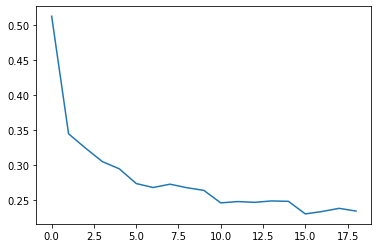

In [ ]:
plt.plot(running_losses)
plt.show()

In [ ]:
# 모델 저장
torch.save(model_Dense.state_dict(),"20181896_model2.pth")

In [ ]:
# 모델 불러오기
test_model = Densenet().to(device)
test_model.load_state_dict(torch.load("20181896_model2.pth"))

<All keys matched successfully>

In [ ]:
# Testing
class_corr=list(0. for i in range(47))
class_tot=list(0. for i in range(47))

test_model.eval()
with torch.no_grad():
  correct=0
  total=0
  for i, (images, labels) in enumerate(test_loader):
    images=images.to(device)
    labels=labels.to(device)
    outputs=test_model(images)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

    c=(predicted==labels).squeeze()
    if i==1817:
      for i in range(35):
        label=labels[i]
        class_corr[label]+=c[i].item()
        class_tot[label]+=1
    else:
      for i in range(64):
        label=labels[i]
        class_corr[label]+=c[i].item()
        class_tot[label]+=1
  print('Accuracy of the network on the {} test images {:.2f}%'.format(len(test_data),100*correct/total))

Accuracy of the network on the 116323 test images 90.97%


In [ ]:
# 각 class별 Accuracy 확인
for i in range(47):
  print('Accuracy of %2d : %.2f%%'%(i,100*class_corr[i]/class_tot[i]))

Accuracy of  0 : 79.58%
Accuracy of  1 : 93.44%
Accuracy of  2 : 97.55%
Accuracy of  3 : 99.54%
Accuracy of  4 : 97.71%
Accuracy of  5 : 92.79%
Accuracy of  6 : 97.22%
Accuracy of  7 : 99.10%
Accuracy of  8 : 98.67%
Accuracy of  9 : 98.44%
Accuracy of 10 : 98.58%
Accuracy of 11 : 97.55%
Accuracy of 12 : 97.36%
Accuracy of 13 : 93.33%
Accuracy of 14 : 98.60%
Accuracy of 15 : 89.24%
Accuracy of 16 : 88.37%
Accuracy of 17 : 96.53%
Accuracy of 18 : 54.87%
Accuracy of 19 : 93.86%
Accuracy of 20 : 98.15%
Accuracy of 21 : 34.99%
Accuracy of 22 : 99.24%
Accuracy of 23 : 98.82%
Accuracy of 24 : 60.62%
Accuracy of 25 : 98.29%
Accuracy of 26 : 95.18%
Accuracy of 27 : 98.44%
Accuracy of 28 : 96.05%
Accuracy of 29 : 93.44%
Accuracy of 30 : 95.81%
Accuracy of 31 : 92.64%
Accuracy of 32 : 98.73%
Accuracy of 33 : 96.66%
Accuracy of 34 : 92.72%
Accuracy of 35 : 85.30%
Accuracy of 36 : 92.87%
Accuracy of 37 : 92.92%
Accuracy of 38 : 98.07%
Accuracy of 39 : 99.04%
Accuracy of 40 : 28.40%
Accuracy of 41 :